# Implementación de la capa de convolución


En este curso, implementaremos una capa de convolución 1D. En el curso sobre capas convolucionales, solo hablamos de la convolución 2D, ya que es la más utilizada. Sin embargo, para comprender bien el código y la ingeniosidad de las capas convolucionales, es esencial empezar por la convolución 1D.


## Convolución 1D: ¿Cómo funciona?


La convolución 1D es bastante similar a la convolución 2D, pero se aplica en una sola dimensión. Al implementar una capa de convolución 1D, se comprende rápidamente por qué una capa convolucional es, en esencia, un bucle *for*.

![conv1d](./images/conv1d.png)

*Figura extraída del [foro](https://ai.stackexchange.com/questions/28767/what-does-channel-mean-in-the-case-of-an-1d-convolution).*

Los parámetros clásicos de la convolución 2D también se aplican aquí:
- El *padding* añade valores en los bordes del vector 1D (al inicio y al final).
- El *stride* define el paso o desplazamiento del filtro.
- La *kernel_size* determina el tamaño del filtro.
- Los *in_channels* y *out_channels* corresponden al número de canales de entrada y salida, respectivamente.
- Entre otros.


## Implementación


Ahora implementaremos la capa de convolución 1D.

**Nota**: En PyTorch, las capas convolucionales no están implementadas en Python, sino en C++ para lograr una mayor velocidad de cálculo.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

En una capa de convolución, tenemos una dimensión de filtro *kernel_size* y un número de filtros *out_channels*. La idea es recorrer todo el vector y calcular los valores de salida aplicando cada filtro en cada posición posible del vector de entrada. En cada posición, se aplica una capa completamente conectada (*fully connected*) que toma como entrada los elementos contenidos en el filtro de tamaño $(KernelSize \times InChannels)$ y devuelve $OutChannels$ elementos. Es como si aplicáramos un bucle *for* en cada posición de la secuencia de entrada.

**Nota**: En la figura explicativa solo aparece una dimensión de canal, pero en la práctica suelen haber varias.


In [14]:
in_channels = 3
out_channels = 16
kernel_size = 3
kernel=nn.Linear(in_channels*kernel_size, out_channels)

Ahora, debemos aplicar esta capa de convolución a todos los elementos de la secuencia con un paso *stride*. También podemos añadir *padding* si queremos que la secuencia de entrada tenga el mismo tamaño que la secuencia de salida.


In [21]:
# Imaginons une séquence de 100 éléments, avec 3 canaux et un batch de 8
dummy_input = torch.randn(8, in_channels, 100)
print("Dimension de l'entrée: ",dummy_input.shape)
stride=1
padding=1
outs=[]

# On pad les deux côtés de l'entrée pour éviter les problèmes de dimensions
dummy_input=F.pad(dummy_input, (padding, padding))

for i in range(kernel_size,dummy_input.shape[2]+1,stride):
  chunk=dummy_input[:,:,i-kernel_size:i]
  # On redimensionne pour la couche fully connected
  chunk=chunk.reshape(dummy_input.shape[0],-1)
  # On applique la couche fully connected
  out=kernel(chunk)
  # On ajoute à la liste des sorties
  outs.append(out)
# On convertit la liste en un tenseur
outs=torch.stack(outs, dim=2)
print("Dimension de la sortie: ",outs.shape)

Dimension de l'entrée:  torch.Size([8, 3, 100])
Dimension de la sortie:  torch.Size([8, 16, 100])


Al igual que en las convoluciones 2D, podemos optar por reducir el tamaño de la secuencia (o de los *feature maps* en el caso de una convolución 2D). Para ello, podemos usar un *stride* mayor que 1 o una capa de *pooling*.

En la práctica, suele preferirse el uso del *stride*, pero implementaremos el *max pooling* para comprender mejor su funcionamiento.


In [27]:
pooling=2
outs2=[]
for i in range(pooling,outs.shape[2]+1,pooling):
  # On prend les éléments entre i-pooling et i
  chunk=outs[:,:,i-pooling:i]
  # On prend le max sur la dimension 2, pour le average pooling on aurait utilisé torch.mean
  out2=torch.max(chunk, dim=2)[0]
  outs2.append(out2)
# On convertit la liste en un tenseur 
outs2=torch.stack(outs2, dim=2)
print("Dimension de la sortie après pooling: ",outs2.shape)

Dimension de la sortie après pooling:  torch.Size([8, 16, 50])


Ahora que hemos comprendido cómo funcionan la convolución 1D y el *max pooling*, crearemos clases para facilitar su uso.


In [29]:
class Conv1D(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size, padding):
    super(Conv1D, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.kernel_width = kernel_size
    self.kernel = nn.Linear(kernel_size * in_channels, out_channels)
    self.padding=padding

  def forward(self, x):
    x=F.pad(x, (self.padding, self.padding))
    # Boucle en une seule ligne pour un code plus concis
    l = [self.kernel(x[:, :, i - self.kernel_width: i].reshape(x.shape[0], self.in_channels * self.kernel_width)) for i in range(self.kernel_width, x.shape[2]+1, self.stride)]
    return torch.stack(l, dim=2)


class MaxPool1D(nn.Module):
  def __init__(self, pooling):
    super(MaxPool1D, self).__init__()
    self.pooling = pooling
    
  def forward(self, x):
    # Boucle en une seule ligne pour un code plus concis
    l = [torch.max(x[:, :, i - self.pooling: i], dim=2)[0] for i in range(self.pooling, x.shape[2]+1, self.pooling)]
    return torch.stack(l, dim=2)

## Caso práctico: MNIST


Ahora que hemos implementado nuestras capas de convolución y *pooling*, las probaremos con el conjunto de datos MNIST. En MNIST se trabajan imágenes, por lo que en la práctica sería más lógico usar convoluciones 2D (ver curso siguiente). Aquí solo verificaremos que nuestra implementación de las convoluciones funcione correctamente.


In [38]:
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Dataset


In [39]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

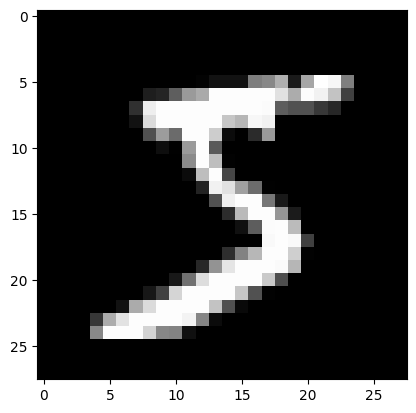

Le chiffre sur l'image est un 0


In [40]:
plt.imshow(dataset[0][0].permute(1,2,0).numpy(), cmap='gray')
plt.show()
print("Le chiffre sur l'image est un "+str(dataset[1][1]))

In [41]:
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Ahora podemos crear nuestro modelo. Observemos que usamos un *stride* de 2 y no aplicamos *max pooling* para ahorrar tiempo en el procesamiento.


In [49]:
class cnn1d(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=Conv1D(1,8,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 8 filtres
    self.conv2=Conv1D(8,16,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 16 filtres
    self.conv3=Conv1D(16,32,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 32 filtres
    self.fc=nn.Linear(3136,10)
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=x.view(-1,x.shape[1]*x.shape[2]) # Pour convertir la feature map de taille CxL en vecteur 1D (avec une dimension batch)
    output=self.fc(x)
    return output
dummy_input=torch.randn(8,1,784)
model=cnn1d()
output=model(dummy_input)
print(output.shape)

print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

torch.Size([8, 10])
Nombre de paramètres 33370


¡El modelo tiene casi 10 veces menos parámetros que nuestro modelo completamente conectado del curso anterior!


In [50]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [51]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    images=images.view(images.shape[0],1,784)
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      images=images.view(images.shape[0],1,784)
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.4011246860027313
step 0 val loss 0.2103319615125656
step 1 train loss 0.17427290976047516
step 1 val loss 0.1769915670156479
step 2 train loss 0.14464063942432404
step 2 val loss 0.14992524683475494
step 3 train loss 0.12802869081497192
step 3 val loss 0.13225941359996796
step 4 train loss 0.11609579622745514
step 4 val loss 0.12663421034812927


In [53]:
correct = 0
total = 0
for images,labels in test_loader:
  images=images.view(images.shape[0],1,784) 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  96.35


Obtenemos una muy buena precisión, aunque ligeramente inferior a la alcanzada con la red completamente conectada del curso anterior.

**Nota**: El entrenamiento fue bastante lento, ya que nuestra implementación no es muy eficiente. La implementación de PyTorch en C++ es mucho más rápida.

**Nota 2**: Hemos utilizado convoluciones 1D para procesar imágenes, lo cual no es óptimo. Lo ideal es emplear convoluciones 2D.


## Bonificaciones : Conv2D


Podemos implementar la convolución 2D siguiendo el mismo principio, pero en dos dimensiones.


In [15]:
in_channels = 3
out_channels = 16
kernel_size = 3
# On a un kernel de taille 3x3 car on est en 2D
kernel=nn.Linear(in_channels*kernel_size**2, out_channels)

In [16]:
# Pour une image de taille 10x10 avec 3 canaux et un batch de 8
dummy_input = torch.randn(8, in_channels, 10,10)
b, c, h, w = dummy_input.shape
print("Dimension de l'entrée: ",dummy_input.shape)
stride=1
padding=1
outs=[]

# Le padding change pour une image 2D, on doit pad en hauteur et en largeur
dummy_input=F.pad(dummy_input, (padding, padding,padding,padding))
print("Dimension de l'entrée après padding: ",dummy_input.shape)

# On boucle sur les dimensions de l'image : W x H 
for i in range(kernel_size,dummy_input.shape[2]+1,stride):
  for j in range(kernel_size,dummy_input.shape[3]+1,stride):
    chunk=dummy_input[:,:,i-kernel_size:i,j-kernel_size:j]
    # On redimensionne pour la couche fully connected
    chunk=chunk.reshape(dummy_input.shape[0],-1)
    # On applique la couche fully connected
    out=kernel(chunk)
    # On ajoute à la liste des sorties
    outs.append(out)
# On convertit la liste en un tenseur
outs=torch.stack(outs, dim=2)
outs=outs.reshape(b,out_channels,h, w)
print("Dimension de la sortie: ",outs.shape)

Dimension de l'entrée:  torch.Size([8, 3, 10, 10])
Dimension de l'entrée après padding:  torch.Size([8, 3, 12, 12])
Dimension de la sortie:  torch.Size([8, 16, 10, 10])


Ahora podemos hacerlo en clase, al igual que con la convolución 1D.


In [34]:
class Conv2D(nn.Module):
  def __init__(self, in_channels, out_channels, stride, kernel_size, padding):
    super(Conv2D, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.kernel_width = kernel_size
    self.kernel = nn.Linear(in_channels*kernel_size**2 , out_channels)
    self.padding=padding

  def forward(self, x):
    b, c, h, w = x.shape
    x=F.pad(x, (self.padding, self.padding,self.padding,self.padding))
    # Sur une seule ligne, c'est absolument illisible, on garde la boucle
    l=[]
    for i in range(self.kernel_width, x.shape[2]+1, self.stride):
      for j in range(self.kernel_width, x.shape[3]+1, self.stride):
        chunk=self.kernel(x[:,:,i-self.kernel_width:i,j-self.kernel_width:j].reshape(x.shape[0],-1))
        l.append(chunk)
    # La version en une ligne, pour les curieux
    #l = [self.kernel(x[:, :, i - self.kernel_width: i, j - self.kernel_width: j].reshape(x.shape[0], ,-1)) for i in range(self.kernel_width, x.shape[2]+1, self.stride) for j in range(self.kernel_width, x.shape[3]+1, self.stride)]
    outs=torch.stack(l, dim=2)
    return outs.reshape(b,self.out_channels,h//self.stride, w//self.stride)

dummy_input=torch.randn(8,3,32,32)
model=Conv2D(3,16,stride=2,kernel_size=3,padding=1)
output=model(dummy_input)
print(output.shape)

torch.Size([8, 16, 16, 16])


Ahora podemos crear nuestro modelo.


In [50]:
class cnn2d(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=Conv2D(1,8,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 8 filtres
    self.conv2=Conv2D(8,16,kernel_size=3,stride=2,padding=1) # Couche de convolution 1D de 16 filtres
    self.conv3=Conv2D(16,32,kernel_size=3,stride=1,padding=1) # Couche de convolution 1D de 32 filtres
    self.fc=nn.Linear(1568,10)
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]) # Pour convertir la feature map de taille CxL en vecteur 1D (avec une dimension batch)
    output=self.fc(x)
    return output
dummy_input=torch.randn(8,1,28,28)
model=cnn2d()
output=model(dummy_input)
print(output.shape)

print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

torch.Size([8, 10])
Nombre de paramètres 21578


Ahora podemos entrenar nuestro modelo con MNIST y ver si obtenemos mejores resultados que con las convoluciones 1D.


In [51]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [52]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.36240848898887634
step 0 val loss 0.14743468165397644
step 1 train loss 0.1063414067029953
step 1 val loss 0.1019362062215805
step 2 train loss 0.07034476101398468
step 2 val loss 0.08669546991586685
step 3 train loss 0.05517915263772011
step 3 val loss 0.07208992540836334
step 4 train loss 0.04452721029520035
step 4 val loss 0.0664198026061058


En términos de *loss*, hemos logrado un valor más bajo que con nuestro modelo de convoluciones 1D.


In [53]:
correct = 0
total = 0
for images,labels in test_loader:
  with torch.no_grad():
    preds=model(images)
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  98.23


¡La precisión es muy buena! Es mejor que la obtenida con los [modelos completamente conectados](../02_RéseauFullyConnected/03_TechniquesAvancées.ipynb), a pesar de tener 10 veces menos parámetros.


**Nota**: Del mismo modo, podemos implementar convoluciones 3D, que se utilizan para el procesamiento de vídeos (se añade el eje temporal).
